In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle

from sklearn.preprocessing import StandardScaler

In [2]:
# Let's use AAPL (Apple), MSI (Motorola), SBUX (Starbucks)
def get_data():
    # returns a T x 3 list of stock prices
    # each row is a different stock
    # 0 = AAPL
    # 1 = MSI
    # 2 = SBUX
    df = pd.read_csv('aapl_msi_sbux.csv')
    return df.values

def get_scaler(env):
    # return scikit-learn scaler object to scale the states
    # Note: you could also populate the replay buffer here

    states = []
    for _ in range(env.n_step):
        action = np.random.choice(env.action_space)
        state, reward, done, info = env.step(action)
        states.append(state)
        if done:
            break

    scaler = StandardScaler()
    scaler.fit(states)
    return scaler

def maybe_make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

***
$ \mathbf{\text{Momentum Gradient Decent}} $<br>
***
$ v(t) = \mu v(t-1)-\alpha g(t) $ <br/>
&nbsp; $ g(t) = $ <em>gradient at time t</em> <br/>
&nbsp; $ \mu = $ <em>momentum term</em> (0.9, 0.99, etc.) <br/>
&nbsp; $ \alpha = $ <em>learning rate</em> <br/>
$ w(t) = w(t-1) + v(t) $ <br/>

***
$ \mathbf{\text{Loss Function}} $<br>
***
$ J = \frac {1}{NK} \sum \limits _{n=1} ^{N} \sum \limits _{k=1} ^{K} (y_{nk} - \hat y_{nk})^2 $ <br/>
$shape(y) = shape(\hat y) = (N,K)$ <br/>
<br/>
<br/>
$ \frac{\partial J}{\partial \theta} = \frac{2}{NK} \sum \limits _{n=1} ^{N} \sum \limits _{k=1} ^{K} (y_{nk} - \hat y_{nk})^2 \frac{\partial \hat y_{nk}}{\partial \theta} \text{, for } \theta = {W, b} $

In [3]:
class LinearModel:
    """ A linear regression model """
    def __init__(self, input_dim, n_action):
        self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
        self.b = np.zeros(n_action)

        # momentum terms
        self.vW = 0
        self.vb = 0

        self.losses = []

    def predict(self, X):
        # make sure X is N x D
        assert(len(X.shape) == 2)
        return X.dot(self.W) + self.b

    def sgd(self, X, Y, learning_rate=0.01, momentum=0.9):
        # make sure X is N x D
        assert(len(X.shape) == 2)

        # the loss values are 2-D
        # normally we would divide by N only
        # but now we divide by N x K
        num_values = np.prod(Y.shape)

        # do one step of gradient descent
        # we multiply by 2 to get the exact gradient
        # (not adjusting the learning rate)
        # i.e. d/dx (x^2) --> 2x
        Yhat = self.predict(X)
        gW = 2 * X.T.dot(Yhat - Y) / num_values
        gb = 2 * (Yhat - Y).sum(axis=0) / num_values

        # update momentum terms
        self.vW = momentum * self.vW - learning_rate * gW
        self.vb = momentum * self.vb - learning_rate * gb

        # update params
        self.W += self.vW
        self.b += self.vb

        mse = np.mean((Yhat - Y)**2)
        self.losses.append(mse)

    def load_weights(self, filepath):
        npz = np.load(filepath)
        self.W = npz['W']
        self.b = npz['b']

    def save_weights(self, filepath):
        np.savez(filepath, W=self.W, b=self.b)

In [4]:
class MultiStockEnv:
    """
    A 3-stock trading environment.
    State: vector of size 7 (n_stock * 2 + 1)
    - # shares of stock 1 owned
    - # shares of stock 2 owned
    - # shares of stock 3 owned
    - price of stock 1 (using daily close price)
    - price of stock 2
    - price of stock 3
    - cash owned (can be used to purchase more stocks)
    Action: categorical variable with 27 (3^3) possibilities
    - for each stock, you can:
    - 0 = sell
    - 1 = hold
    - 2 = buy
    """

    def __init__(self, data, initial_investment=20000):
        # data
        self.stock_price_history = data
        self.n_step, self.n_stock = self.stock_price_history.shape

        # instance attributes
        self.initial_investment = initial_investment
        self.cur_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None

        self.action_space = np.arange(3**self.n_stock)

        # action permutations
        # returns a nested list with elements like:
        # [0,0,0]
        # [0,0,1]
        # [0,0,2]
        # [0,1,0]
        # [0,1,1]
        # etc.
        # 0 = sell
        # 1 = hold
        # 2 = buy
        self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

        # calculate size of state
        self.state_dim = self.n_stock * 2 + 1

        self.reset()
        
    def reset(self):
        self.cur_step = 0
        self.stock_owned = np.zeros(self.n_stock)
        self.stock_price = self.stock_price_history[self.cur_step]
        self.cash_in_hand = self.initial_investment
        return self._get_obs()
        
    def step(self, action):
        assert action in self.action_space
        
        # get current value before performing the action
        prev_val = self._get_val()
        
        #update price, i.e. go to the next day
        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]
        
        # perform the trade
        self._trade(action)
        
        # get the new value after taking the action
        cur_val = self._get_val()
        
        # reward is the increase in porfolio value
        reward = cur_val - prev_val
        
        # done if we have run out of data
        done = self.cur_step == self.n_step - 1
        
        # store the current value of the portfolio here
        info = {'cur_val': cur_val}
        
        # conform to the Gym API
        return self._get_obs(), reward, done, info
    
    def _get_obs(self):
        obs = np.empty(self.state_dim)
        obs[:self.n_stock] = self.stock_owned
        obs[self.n_stock:2*self.n_stock] = self.stock_price
        obs[-1] = self.cash_in_hand
        return obs
    
    def _get_val(self):
        return self.stock_owned.dot(self.stock_price) + self.cash_in_hand
    
    def _trade(self, action):
        # index the action we want to perform
        # 0 = sell
        # 1 = hold
        # 2 = buy
        # e.g. [2,1,0] means:
        # buy first stock
        # hold second stock
        # sell third stock
        action_vec = self.action_list[action]
        
        # determine which stocks to buy or sell
        sell_index = []
        buy_index = []
        
        for i, a in enumerate(action_vec):
            if a == 0:
                sell_index.append(i)
            elif a == 2:
                buy_index.append(i)
                
        # sell any stocks we want to sell
        # then buy any stocks we want to buy
        if sell_index:
            # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
            for i in sell_index:
                for i in sell_index:
                    self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
                    self.stock_owned[i] = 0
        if buy_index:
            # NOTE: when buying, we will loop through each stock we want to buy,
            #       and buy one share at a time until we run out of cash
            can_buy = True
            while can_buy:
                for i in buy_index:
                    if self.cash_in_hand > self.stock_price[i]:
                        self.stock_owned[i] += 1
                        self.cash_in_hand -= self.stock_price[i]
                    else:
                        can_buy = False

In [5]:
class DQNAgent(object):
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = LinearModel(state_size, action_size)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action


    def train(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.model.predict(next_state), axis=1)

        target_full = self.model.predict(state)
        target_full[0, action] = target

        # Run one training step
        self.model.sgd(state, target_full)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    def load(self, name):
        self.model.load_weights(name)


    def save(self, name):
        self.model.save_weights(name)

In [6]:
def play_one_episode(agent, env, is_train):
    # note: after transforming states are already 1xD
    state = env.reset()
    state = scaler.transform([state])
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        if is_train == 'train':
            agent.train(state, action, reward, next_state, done)
        state = next_state

    return info['cur_val']

In [7]:
# config
models_folder = 'linear_rl_trader_models'
rewards_folder = 'linear_rl_trader_rewards'
num_episodes = 2000
batch_size = 32
initial_investment = 20000


maybe_make_dir(models_folder)
maybe_make_dir(rewards_folder)

data = get_data()
n_timesteps, n_stocks = data.shape

n_train = n_timesteps // 2

train_data = data[:n_train]
test_data = data[n_train:]

env = MultiStockEnv(train_data, initial_investment)
state_size = env.state_dim
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)
scaler = get_scaler(env)

# store the final value of the portfolio (end of episode)
portfolio_value = []

episode: 1/2000, episode end value: 34390.32, duration: 0:00:00.166495
episode: 2/2000, episode end value: 38370.37, duration: 0:00:00.116044
episode: 3/2000, episode end value: 37313.27, duration: 0:00:00.121656
episode: 4/2000, episode end value: 31851.10, duration: 0:00:00.138845
episode: 5/2000, episode end value: 37395.71, duration: 0:00:00.114996
episode: 6/2000, episode end value: 27873.65, duration: 0:00:00.142295
episode: 7/2000, episode end value: 33664.95, duration: 0:00:00.138600
episode: 8/2000, episode end value: 28622.61, duration: 0:00:00.127428
episode: 9/2000, episode end value: 34685.31, duration: 0:00:00.136886
episode: 10/2000, episode end value: 37458.74, duration: 0:00:00.139322
episode: 11/2000, episode end value: 34449.33, duration: 0:00:00.134785
episode: 12/2000, episode end value: 38548.78, duration: 0:00:00.141480
episode: 13/2000, episode end value: 32031.70, duration: 0:00:00.121426
episode: 14/2000, episode end value: 30305.93, duration: 0:00:00.122962
e

episode: 115/2000, episode end value: 47823.10, duration: 0:00:00.404946
episode: 116/2000, episode end value: 40538.26, duration: 0:00:00.354817
episode: 117/2000, episode end value: 44282.07, duration: 0:00:00.345284
episode: 118/2000, episode end value: 38455.96, duration: 0:00:00.335545
episode: 119/2000, episode end value: 34106.65, duration: 0:00:00.315749
episode: 120/2000, episode end value: 49227.66, duration: 0:00:00.281789
episode: 121/2000, episode end value: 59507.46, duration: 0:00:00.166347
episode: 122/2000, episode end value: 52557.71, duration: 0:00:00.258745
episode: 123/2000, episode end value: 66890.64, duration: 0:00:00.357704
episode: 124/2000, episode end value: 26344.58, duration: 0:00:00.292632
episode: 125/2000, episode end value: 32036.17, duration: 0:00:00.287487
episode: 126/2000, episode end value: 40346.79, duration: 0:00:00.345393
episode: 127/2000, episode end value: 46682.52, duration: 0:00:00.295709
episode: 128/2000, episode end value: 61525.86, dur

episode: 228/2000, episode end value: 47206.32, duration: 0:00:00.419322
episode: 229/2000, episode end value: 55316.54, duration: 0:00:00.452358
episode: 230/2000, episode end value: 50394.93, duration: 0:00:00.429524
episode: 231/2000, episode end value: 56683.27, duration: 0:00:00.434008
episode: 232/2000, episode end value: 45968.48, duration: 0:00:00.382799
episode: 233/2000, episode end value: 48587.17, duration: 0:00:00.382037
episode: 234/2000, episode end value: 46631.42, duration: 0:00:00.319861
episode: 235/2000, episode end value: 45570.55, duration: 0:00:00.368803
episode: 236/2000, episode end value: 42391.60, duration: 0:00:00.173912
episode: 237/2000, episode end value: 52659.62, duration: 0:00:00.296939
episode: 238/2000, episode end value: 58790.16, duration: 0:00:00.427043
episode: 239/2000, episode end value: 51049.49, duration: 0:00:00.475225
episode: 240/2000, episode end value: 40943.06, duration: 0:00:00.405950
episode: 241/2000, episode end value: 43530.64, dur

episode: 341/2000, episode end value: 50709.79, duration: 0:00:00.280929
episode: 342/2000, episode end value: 46517.63, duration: 0:00:00.358695
episode: 343/2000, episode end value: 42277.73, duration: 0:00:00.369699
episode: 344/2000, episode end value: 40103.59, duration: 0:00:00.326152
episode: 345/2000, episode end value: 40319.32, duration: 0:00:00.341007
episode: 346/2000, episode end value: 36027.91, duration: 0:00:00.348153
episode: 347/2000, episode end value: 40782.95, duration: 0:00:00.144318
episode: 348/2000, episode end value: 32760.51, duration: 0:00:00.278135
episode: 349/2000, episode end value: 36340.19, duration: 0:00:00.138530
episode: 350/2000, episode end value: 36242.39, duration: 0:00:00.150976
episode: 351/2000, episode end value: 40337.18, duration: 0:00:00.125493
episode: 352/2000, episode end value: 47743.68, duration: 0:00:00.357117
episode: 353/2000, episode end value: 47984.69, duration: 0:00:00.419426
episode: 354/2000, episode end value: 46041.52, dur

episode: 454/2000, episode end value: 47815.59, duration: 0:00:00.276076
episode: 455/2000, episode end value: 47105.93, duration: 0:00:00.296753
episode: 456/2000, episode end value: 44932.46, duration: 0:00:00.344708
episode: 457/2000, episode end value: 55984.01, duration: 0:00:00.355359
episode: 458/2000, episode end value: 47149.92, duration: 0:00:00.360648
episode: 459/2000, episode end value: 49547.77, duration: 0:00:00.355250
episode: 460/2000, episode end value: 56236.39, duration: 0:00:00.156763
episode: 461/2000, episode end value: 40362.31, duration: 0:00:00.311959
episode: 462/2000, episode end value: 46070.87, duration: 0:00:00.344038
episode: 463/2000, episode end value: 65589.22, duration: 0:00:00.381843
episode: 464/2000, episode end value: 39819.28, duration: 0:00:00.325877
episode: 465/2000, episode end value: 44069.96, duration: 0:00:00.337532
episode: 466/2000, episode end value: 49290.62, duration: 0:00:00.362808
episode: 467/2000, episode end value: 38090.37, dur

episode: 569/2000, episode end value: 53176.34, duration: 0:00:00.257968
episode: 570/2000, episode end value: 51367.15, duration: 0:00:00.297782
episode: 571/2000, episode end value: 43021.43, duration: 0:00:00.274423
episode: 572/2000, episode end value: 37172.15, duration: 0:00:00.219038
episode: 573/2000, episode end value: 48204.23, duration: 0:00:00.281541
episode: 574/2000, episode end value: 44000.83, duration: 0:00:00.283242
episode: 575/2000, episode end value: 35182.62, duration: 0:00:00.230247
episode: 576/2000, episode end value: 54868.26, duration: 0:00:00.149451
episode: 577/2000, episode end value: 42590.08, duration: 0:00:00.123923
episode: 578/2000, episode end value: 50995.60, duration: 0:00:00.141303
episode: 579/2000, episode end value: 47456.23, duration: 0:00:00.130454
episode: 580/2000, episode end value: 53683.28, duration: 0:00:00.165474
episode: 581/2000, episode end value: 44253.99, duration: 0:00:00.160633
episode: 582/2000, episode end value: 44169.10, dur

episode: 682/2000, episode end value: 58190.67, duration: 0:00:00.291129
episode: 683/2000, episode end value: 46722.82, duration: 0:00:00.301466
episode: 684/2000, episode end value: 55178.49, duration: 0:00:00.376774
episode: 685/2000, episode end value: 33904.01, duration: 0:00:00.308228
episode: 686/2000, episode end value: 49368.83, duration: 0:00:00.331587
episode: 687/2000, episode end value: 54434.68, duration: 0:00:00.334152
episode: 688/2000, episode end value: 45711.99, duration: 0:00:00.330733
episode: 689/2000, episode end value: 43272.40, duration: 0:00:00.345957
episode: 690/2000, episode end value: 40382.35, duration: 0:00:00.329557
episode: 691/2000, episode end value: 55080.01, duration: 0:00:00.148210
episode: 692/2000, episode end value: 46901.06, duration: 0:00:00.150536
episode: 693/2000, episode end value: 47129.25, duration: 0:00:00.178084
episode: 694/2000, episode end value: 49321.30, duration: 0:00:00.265277
episode: 695/2000, episode end value: 38969.13, dur

episode: 795/2000, episode end value: 46776.61, duration: 0:00:00.375263
episode: 796/2000, episode end value: 62311.07, duration: 0:00:00.368482
episode: 797/2000, episode end value: 74796.15, duration: 0:00:00.399479
episode: 798/2000, episode end value: 45002.07, duration: 0:00:00.325376
episode: 799/2000, episode end value: 57455.58, duration: 0:00:00.386998
episode: 800/2000, episode end value: 72040.75, duration: 0:00:00.514043
episode: 801/2000, episode end value: 51400.37, duration: 0:00:00.369228
episode: 802/2000, episode end value: 38597.30, duration: 0:00:00.323044
episode: 803/2000, episode end value: 56392.96, duration: 0:00:00.394296
episode: 804/2000, episode end value: 54016.45, duration: 0:00:00.185263
episode: 805/2000, episode end value: 43610.68, duration: 0:00:00.302291
episode: 806/2000, episode end value: 51048.81, duration: 0:00:00.371145
episode: 807/2000, episode end value: 56547.48, duration: 0:00:00.184543
episode: 808/2000, episode end value: 60365.66, dur

episode: 908/2000, episode end value: 43565.57, duration: 0:00:00.373120
episode: 909/2000, episode end value: 46469.38, duration: 0:00:00.307332
episode: 910/2000, episode end value: 41843.58, duration: 0:00:00.182093
episode: 911/2000, episode end value: 47391.32, duration: 0:00:00.168878
episode: 912/2000, episode end value: 58851.58, duration: 0:00:00.344778
episode: 913/2000, episode end value: 58046.01, duration: 0:00:00.200949
episode: 914/2000, episode end value: 50289.27, duration: 0:00:00.332334
episode: 915/2000, episode end value: 50071.92, duration: 0:00:00.344143
episode: 916/2000, episode end value: 41138.79, duration: 0:00:00.266272
episode: 917/2000, episode end value: 43300.56, duration: 0:00:00.302031
episode: 918/2000, episode end value: 49047.34, duration: 0:00:00.350052
episode: 919/2000, episode end value: 60314.30, duration: 0:00:00.410217
episode: 920/2000, episode end value: 55338.43, duration: 0:00:00.345578
episode: 921/2000, episode end value: 42559.58, dur

episode: 1020/2000, episode end value: 44091.94, duration: 0:00:00.263065
episode: 1021/2000, episode end value: 33444.92, duration: 0:00:00.201920
episode: 1022/2000, episode end value: 53356.03, duration: 0:00:00.334896
episode: 1023/2000, episode end value: 37514.74, duration: 0:00:00.298228
episode: 1024/2000, episode end value: 52952.37, duration: 0:00:00.315722
episode: 1025/2000, episode end value: 49797.47, duration: 0:00:00.319500
episode: 1026/2000, episode end value: 41814.10, duration: 0:00:00.334092
episode: 1027/2000, episode end value: 49842.91, duration: 0:00:00.351453
episode: 1028/2000, episode end value: 22603.91, duration: 0:00:00.192481
episode: 1029/2000, episode end value: 43973.03, duration: 0:00:00.171591
episode: 1030/2000, episode end value: 37469.79, duration: 0:00:00.283569
episode: 1031/2000, episode end value: 38178.08, duration: 0:00:00.231235
episode: 1032/2000, episode end value: 42443.19, duration: 0:00:00.174722
episode: 1033/2000, episode end value:

episode: 1131/2000, episode end value: 49673.61, duration: 0:00:00.195363
episode: 1132/2000, episode end value: 44767.43, duration: 0:00:00.225318
episode: 1133/2000, episode end value: 50917.15, duration: 0:00:00.243381
episode: 1134/2000, episode end value: 40161.80, duration: 0:00:00.152297
episode: 1135/2000, episode end value: 46683.54, duration: 0:00:00.199317
episode: 1136/2000, episode end value: 31478.71, duration: 0:00:00.232943
episode: 1137/2000, episode end value: 54721.39, duration: 0:00:00.285394
episode: 1138/2000, episode end value: 42481.03, duration: 0:00:00.324474
episode: 1139/2000, episode end value: 50826.85, duration: 0:00:00.301096
episode: 1140/2000, episode end value: 48387.07, duration: 0:00:00.281862
episode: 1141/2000, episode end value: 72989.78, duration: 0:00:00.403931
episode: 1142/2000, episode end value: 53245.51, duration: 0:00:00.434138
episode: 1143/2000, episode end value: 49751.03, duration: 0:00:00.290276
episode: 1144/2000, episode end value:

episode: 1243/2000, episode end value: 45324.58, duration: 0:00:00.335397
episode: 1244/2000, episode end value: 46111.65, duration: 0:00:00.223320
episode: 1245/2000, episode end value: 56719.15, duration: 0:00:00.248488
episode: 1246/2000, episode end value: 66355.87, duration: 0:00:00.334409
episode: 1247/2000, episode end value: 52900.52, duration: 0:00:00.317221
episode: 1248/2000, episode end value: 44705.94, duration: 0:00:00.303209
episode: 1249/2000, episode end value: 41726.70, duration: 0:00:00.324172
episode: 1250/2000, episode end value: 57388.52, duration: 0:00:00.370098
episode: 1251/2000, episode end value: 42678.29, duration: 0:00:00.316016
episode: 1252/2000, episode end value: 63332.10, duration: 0:00:00.336801
episode: 1253/2000, episode end value: 62315.23, duration: 0:00:00.400792
episode: 1254/2000, episode end value: 69373.77, duration: 0:00:00.319596
episode: 1255/2000, episode end value: 49371.11, duration: 0:00:00.355998
episode: 1256/2000, episode end value:

episode: 1355/2000, episode end value: 32333.74, duration: 0:00:00.207940
episode: 1356/2000, episode end value: 52249.28, duration: 0:00:00.206427
episode: 1357/2000, episode end value: 63864.88, duration: 0:00:00.175165
episode: 1358/2000, episode end value: 47676.64, duration: 0:00:00.210866
episode: 1359/2000, episode end value: 52007.67, duration: 0:00:00.233819
episode: 1360/2000, episode end value: 53425.00, duration: 0:00:00.244308
episode: 1361/2000, episode end value: 45404.90, duration: 0:00:00.225312
episode: 1362/2000, episode end value: 46380.52, duration: 0:00:00.264921
episode: 1363/2000, episode end value: 43846.85, duration: 0:00:00.239270
episode: 1364/2000, episode end value: 54793.41, duration: 0:00:00.458520
episode: 1365/2000, episode end value: 50082.07, duration: 0:00:00.367264
episode: 1366/2000, episode end value: 49841.94, duration: 0:00:00.228799
episode: 1367/2000, episode end value: 49236.82, duration: 0:00:00.261629
episode: 1368/2000, episode end value:

episode: 1466/2000, episode end value: 60443.18, duration: 0:00:00.390741
episode: 1467/2000, episode end value: 45398.12, duration: 0:00:00.269781
episode: 1468/2000, episode end value: 60360.19, duration: 0:00:00.337172
episode: 1469/2000, episode end value: 40307.77, duration: 0:00:00.495776
episode: 1470/2000, episode end value: 59056.13, duration: 0:00:00.685365
episode: 1471/2000, episode end value: 40975.22, duration: 0:00:00.290831
episode: 1472/2000, episode end value: 58990.33, duration: 0:00:00.397703
episode: 1473/2000, episode end value: 54965.30, duration: 0:00:00.305255
episode: 1474/2000, episode end value: 42751.09, duration: 0:00:00.293222
episode: 1475/2000, episode end value: 44537.06, duration: 0:00:00.287790
episode: 1476/2000, episode end value: 62447.92, duration: 0:00:00.358100
episode: 1477/2000, episode end value: 43084.20, duration: 0:00:00.418099
episode: 1478/2000, episode end value: 50216.30, duration: 0:00:00.837921
episode: 1479/2000, episode end value:

episode: 1577/2000, episode end value: 48889.16, duration: 0:00:00.405291
episode: 1578/2000, episode end value: 63326.93, duration: 0:00:00.448827
episode: 1579/2000, episode end value: 52876.50, duration: 0:00:00.290052
episode: 1580/2000, episode end value: 54759.39, duration: 0:00:00.357992
episode: 1581/2000, episode end value: 72817.73, duration: 0:00:00.466564
episode: 1582/2000, episode end value: 59160.35, duration: 0:00:00.286576
episode: 1583/2000, episode end value: 48525.79, duration: 0:00:00.390305
episode: 1584/2000, episode end value: 43073.47, duration: 0:00:00.387161
episode: 1585/2000, episode end value: 39148.94, duration: 0:00:00.230066
episode: 1586/2000, episode end value: 45098.38, duration: 0:00:00.267525
episode: 1587/2000, episode end value: 56792.52, duration: 0:00:00.299092
episode: 1588/2000, episode end value: 71104.17, duration: 0:00:00.483322
episode: 1589/2000, episode end value: 43973.48, duration: 0:00:00.388188
episode: 1590/2000, episode end value:

episode: 1688/2000, episode end value: 42707.18, duration: 0:00:00.357543
episode: 1689/2000, episode end value: 52993.18, duration: 0:00:00.381921
episode: 1690/2000, episode end value: 66718.33, duration: 0:00:00.401291
episode: 1691/2000, episode end value: 54117.26, duration: 0:00:00.421079
episode: 1692/2000, episode end value: 41852.83, duration: 0:00:00.195849
episode: 1693/2000, episode end value: 58334.27, duration: 0:00:00.180394
episode: 1694/2000, episode end value: 52506.19, duration: 0:00:00.139742
episode: 1695/2000, episode end value: 55927.12, duration: 0:00:00.310356
episode: 1696/2000, episode end value: 50921.20, duration: 0:00:00.347479
episode: 1697/2000, episode end value: 54900.88, duration: 0:00:00.351980
episode: 1698/2000, episode end value: 57889.67, duration: 0:00:00.248183
episode: 1699/2000, episode end value: 33423.19, duration: 0:00:00.408215
episode: 1700/2000, episode end value: 49262.69, duration: 0:00:00.263457
episode: 1701/2000, episode end value:

episode: 1799/2000, episode end value: 53148.93, duration: 0:00:00.371495
episode: 1800/2000, episode end value: 43131.84, duration: 0:00:00.337151
episode: 1801/2000, episode end value: 42308.63, duration: 0:00:00.274380
episode: 1802/2000, episode end value: 50293.01, duration: 0:00:00.366856
episode: 1803/2000, episode end value: 39945.67, duration: 0:00:00.333307
episode: 1804/2000, episode end value: 56728.13, duration: 0:00:00.305041
episode: 1805/2000, episode end value: 51412.56, duration: 0:00:00.388628
episode: 1806/2000, episode end value: 59185.19, duration: 0:00:00.419754
episode: 1807/2000, episode end value: 45010.19, duration: 0:00:00.342034
episode: 1808/2000, episode end value: 48527.17, duration: 0:00:00.392764
episode: 1809/2000, episode end value: 52675.02, duration: 0:00:00.339727
episode: 1810/2000, episode end value: 41634.79, duration: 0:00:00.240111
episode: 1811/2000, episode end value: 67075.97, duration: 0:00:00.339474
episode: 1812/2000, episode end value:

episode: 1910/2000, episode end value: 67387.51, duration: 0:00:00.174337
episode: 1911/2000, episode end value: 57457.97, duration: 0:00:00.190524
episode: 1912/2000, episode end value: 68909.42, duration: 0:00:00.240769
episode: 1913/2000, episode end value: 60374.95, duration: 0:00:00.212705
episode: 1914/2000, episode end value: 60229.57, duration: 0:00:00.195453
episode: 1915/2000, episode end value: 60251.25, duration: 0:00:00.248178
episode: 1916/2000, episode end value: 57099.99, duration: 0:00:00.215803
episode: 1917/2000, episode end value: 57614.86, duration: 0:00:00.249476
episode: 1918/2000, episode end value: 69698.68, duration: 0:00:00.217603
episode: 1919/2000, episode end value: 64506.45, duration: 0:00:00.280780
episode: 1920/2000, episode end value: 41873.63, duration: 0:00:00.337712
episode: 1921/2000, episode end value: 50755.99, duration: 0:00:00.380898
episode: 1922/2000, episode end value: 34723.06, duration: 0:00:00.289936
episode: 1923/2000, episode end value:

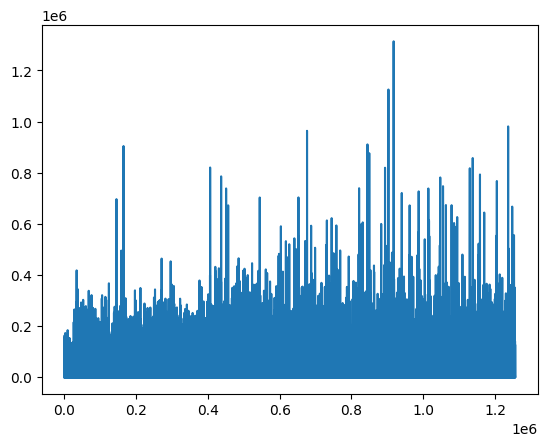

In [8]:
mode = 'train'

# play the game num_episodes times
for e in range(num_episodes):
    t0 = datetime.now()
    val = play_one_episode(agent, env, mode)
    dt = datetime.now() - t0
    print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
    portfolio_value.append(val) # append episode end portfolio value

# save the DQN
agent.save(f'{models_folder}/linear.npz')

# save the scaler
with open(f'{models_folder}/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# plot losses
plt.plot(agent.model.losses)
plt.show()

# save portfolio value for each episode
np.save(f'{rewards_folder}/{mode}.npy', portfolio_value)

average reward: 48367.20, min: 20770.79, max: 86658.85


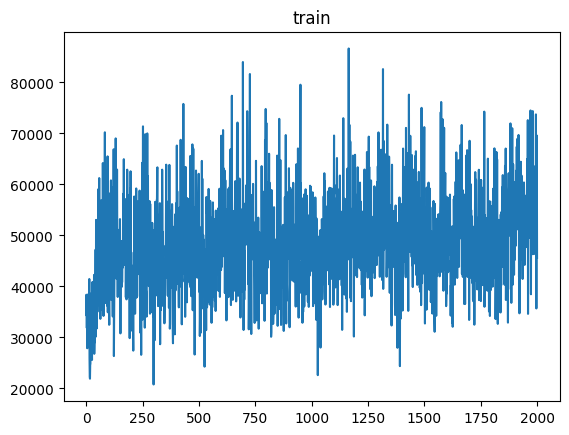

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import argparse


a = np.load(f'linear_rl_trader_rewards/{mode}.npy')

print(f"average reward: {a.mean():.2f}, min: {a.min():.2f}, max: {a.max():.2f}")

plt.plot(a)

plt.title(mode)
plt.show()

In [10]:
mode = "train"
portfolio_value = []

# then load the previous scaler
with open(f'{models_folder}/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# remake the env with test data
env = MultiStockEnv(train_data, initial_investment)

# load trained weights
agent.load(f'{models_folder}/linear.npz')

# make sure epsilon is not 1!
# no need to run multiple episodes if epsilon = 0, it's deterministic
agent.epsilon = 0

# play the game num_episodes times
state = env.reset()
state = scaler.transform([state])
done = False

train_trading_data = pd.DataFrame(data=train_data, columns=['AAPL', 'MSI', 'SBUX'])
actions = []

while not done:
    action = agent.act(state)
    # apending action taken
    actions.append(env.action_list[19])
    next_state, reward, done, info = env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state

In [11]:
action_data = pd.DataFrame(data=actions, columns=['AAPL_A', 'MSI_A', 'SBUX_A']) 
strategy_data = pd.concat([train_trading_data, action_data], axis=1)

In [18]:
strategy_data

,AAPL,MSI,SBUX,AAPL_A,MSI_A,SBUX_A
0,119.72,63.99,56.27,2.0,0.0,1.0
1,113.49,63.35,56.35,2.0,0.0,1.0
2,115.24,64.60,56.38,2.0,0.0,1.0
3,115.15,64.34,56.85,2.0,0.0,1.0
4,115.96,64.98,57.10,2.0,0.0,1.0
...,...,...,...,...,...,...
625,167.78,99.12,56.00,2.0,0.0,1.0
626,160.50,103.87,55.77,2.0,0.0,1.0
627,156.49,101.06,54.69,2.0,0.0,1.0
628,163.03,102.76,55.61,2.0,0.0,1.0


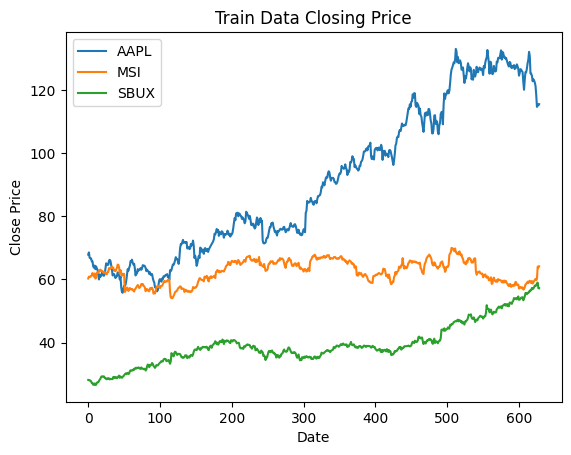

In [12]:
plt.plot(train_data)
plt.legend(['AAPL', 'MSI', 'SBUX'],loc='best')
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('Train Data Closing Price') 
plt.show()

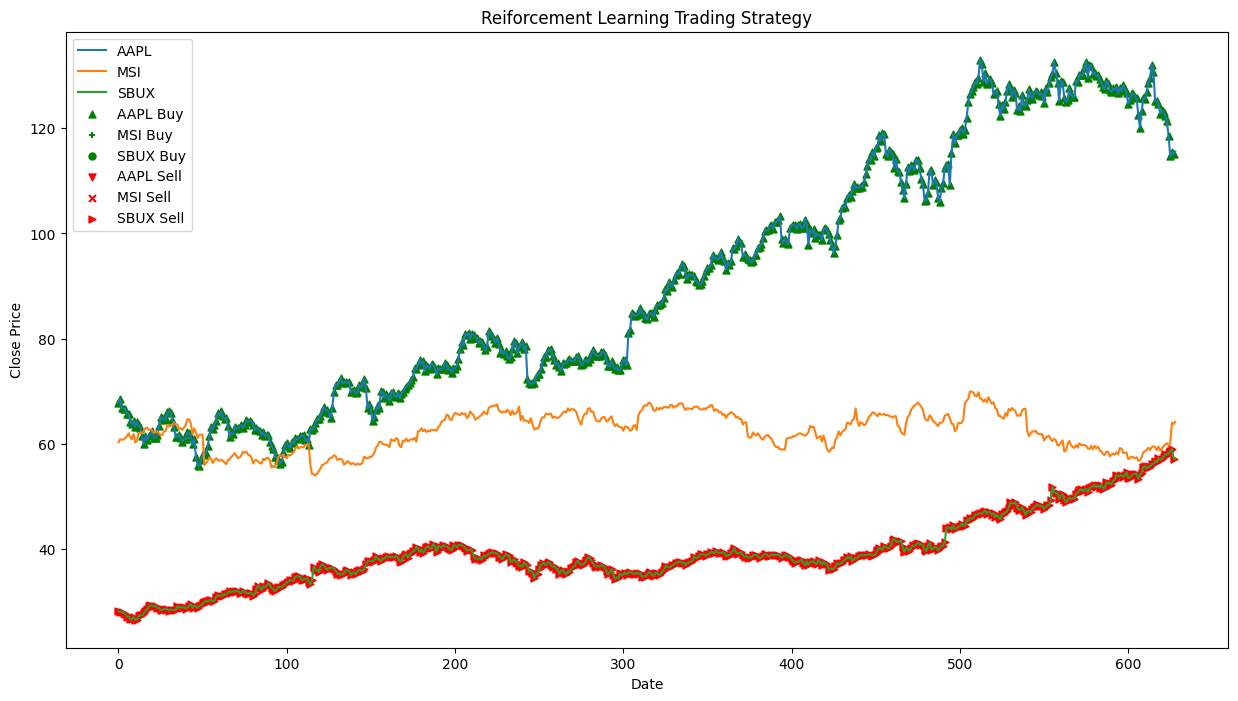

In [13]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(111)

ax1.plot(
    train_trading_data,
    label=['AAPL', 'MSI', 'SBUX']
)

# buy signals
ax1.scatter(
    strategy_data.loc[strategy_data['AAPL_A'] == 2].index, 
    strategy_data.loc[strategy_data['AAPL_A'] == 2].AAPL,
    label='AAPL Buy', 
    color='green', 
    s=25, 
    marker="^"
)

ax1.scatter(
    strategy_data.loc[strategy_data['MSI_A'] == 2].index, 
    strategy_data.loc[strategy_data['MSI_A'] == 2].MSI,
    label='MSI Buy', 
    color='green', 
    s=25, 
    marker="+"
)

ax1.scatter(
    strategy_data.loc[strategy_data['SBUX_A'] == 2].index, 
    strategy_data.loc[strategy_data['SBUX_A'] == 2].SBUX,
    label='SBUX Buy', 
    color='green', 
    s=25, 
    marker="o"
)

# sell signals
ax1.scatter(
    strategy_data.loc[strategy_data['AAPL_A'] == 1].index, 
    strategy_data.loc[strategy_data['AAPL_A'] == 1].AAPL,
    label='AAPL Sell', 
    color='red', 
    s=25, 
    marker="v"
)

ax1.scatter(
    strategy_data.loc[strategy_data['MSI_A'] == 1].index, 
    strategy_data.loc[strategy_data['MSI_A'] == 1].MSI,
    label='MSI Sell', 
    color='red', 
    s=25, 
    marker="x"
)

ax1.scatter(
    strategy_data.loc[strategy_data['SBUX_A'] == 1].index, 
    strategy_data.loc[strategy_data['SBUX_A'] == 1].SBUX,
    label='SBUX Sell', 
    color='red', 
    s=25, 
    marker=">"
)

plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('Reiforcement Learning Trading Strategy') 
plt.legend(loc='best')
plt.show()

In [14]:
mode = "test"
portfolio_value = []

# then load the previous scaler
with open(f'{models_folder}/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# remake the env with test data
env = MultiStockEnv(test_data, initial_investment)

# load trained weights
agent.load(f'{models_folder}/linear.npz')

# make sure epsilon is not 1!
# no need to run multiple episodes if epsilon = 0, it's deterministic
agent.epsilon = 0

# play the game num_episodes times
state = env.reset()
state = scaler.transform([state])
done = False

test_trading_data = pd.DataFrame(data=test_data, columns=['AAPL', 'MSI', 'SBUX'])
actions = []

while not done:
    action = agent.act(state)
    # apending action taken
    actions.append(env.action_list[19])
    next_state, reward, done, info = env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state
    
    
# portfolio_value.append(val) # append episode end portfolio value

# save portfolio value for each episode
# np.save(f'{rewards_folder}/{mode}.npy', portfolio_value)

In [15]:
action_data = pd.DataFrame(data=actions, columns=['AAPL_A', 'MSI_A', 'SBUX_A']) 
strategy_data = pd.concat([test_trading_data, action_data], axis=1)

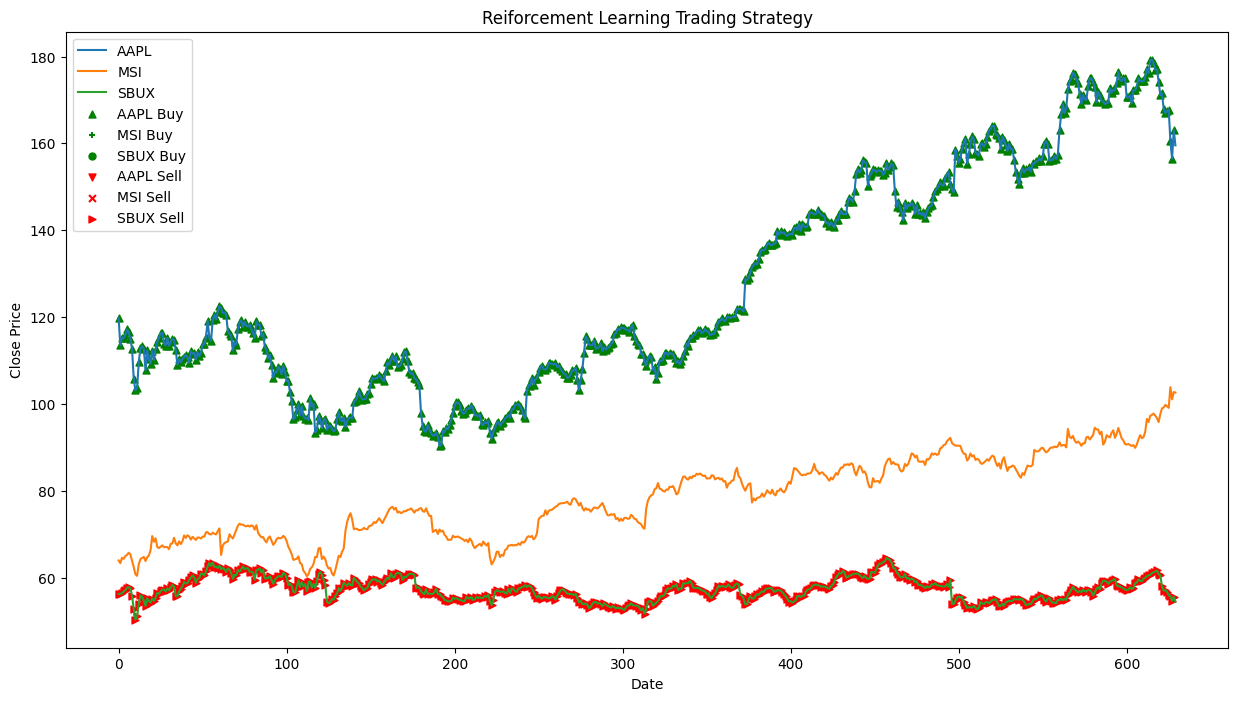

In [16]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(111)

ax1.plot(
    test_trading_data,
    label=['AAPL', 'MSI', 'SBUX']
)

# buy signals
ax1.scatter(
    strategy_data.loc[strategy_data['AAPL_A'] == 2].index, 
    strategy_data.loc[strategy_data['AAPL_A'] == 2].AAPL,
    label='AAPL Buy', 
    color='green', 
    s=25, 
    marker="^"
)

ax1.scatter(
    strategy_data.loc[strategy_data['MSI_A'] == 2].index, 
    strategy_data.loc[strategy_data['MSI_A'] == 2].MSI,
    label='MSI Buy', 
    color='green', 
    s=25, 
    marker="+"
)

ax1.scatter(
    strategy_data.loc[strategy_data['SBUX_A'] == 2].index, 
    strategy_data.loc[strategy_data['SBUX_A'] == 2].SBUX,
    label='SBUX Buy', 
    color='green', 
    s=25, 
    marker="o"
)

# sell signals
ax1.scatter(
    strategy_data.loc[strategy_data['AAPL_A'] == 1].index, 
    strategy_data.loc[strategy_data['AAPL_A'] == 1].AAPL,
    label='AAPL Sell', 
    color='red', 
    s=25, 
    marker="v"
)

ax1.scatter(
    strategy_data.loc[strategy_data['MSI_A'] == 1].index, 
    strategy_data.loc[strategy_data['MSI_A'] == 1].MSI,
    label='MSI Sell', 
    color='red', 
    s=25, 
    marker="x"
)

ax1.scatter(
    strategy_data.loc[strategy_data['SBUX_A'] == 1].index, 
    strategy_data.loc[strategy_data['SBUX_A'] == 1].SBUX,
    label='SBUX Sell', 
    color='red', 
    s=25, 
    marker=">"
)

plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('Reiforcement Learning Trading Strategy') 
plt.legend(loc='best')
plt.show()

In [17]:
# model.predict(state)